# Neuronal Functional Connectivity Estimation

In [1]:
from copy import deepcopy
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from scipy import linalg
import seaborn as sns
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

import evals
import globals as glb
import utils
import plot_utils
from data_loader import SpontaneousRecordingData
from data_loader import GratingStimuliRecordingData # Recording with Grating Stimuli
from data_loader import VisualStimuliRecordingData # Recording with Image Stimuli

from NearestPSD import shrinking, nearest_correlation

from data_sampler import MissingTraceSampler, PartialSpontRecordingData
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf


The datasets we use for this project is published by Carsen Stringer at https://janelia.figshare.com/articles/dataset/Recordings_of_10k_neurons_in_V1_during_drifting_gratings/6214019  
  
<font color=brown> To run the following code, please make sure you have the dataset downloaded locally and set its local path to the 'DATA_DIR' variable below.</font>

# Load Spontaneous Activity Datasets
Change the following DATA_DIR to your local data directory!

In [2]:
DATA_DIR = "D:/MIT MFin/2021 Spring/Harvard Cross-reg/ENG-SCI 201 231/Project/ExpData/"
spont_mat = scipy.io.loadmat(DATA_DIR + "dbspont.mat").get("db")[0]  # 9 datasets of recordings

In [3]:
# Session 1: Around 120 mins
SIDX = 0
spont0_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], spont_mat[SIDX][glb.REC_DATE][0]])
spont_dataset0 = SpontaneousRecordingData(data_fp=spont0_fp)

Removing 1 all-zero columns


In [4]:
# Basic statistics about the dataset
spont_dataset0.display_field_shapes()

neuron counts: 11983
layer counts: 9
Layer 0: 1131 neurons
Layer 1: 1183 neurons
Layer 2: 1218 neurons
Layer 3: 1321 neurons
Layer 4: 1415 neurons
Layer 5: 1471 neurons
Layer 6: 1418 neurons
Layer 7: 1440 neurons
Layer 8: 1386 neurons
timestamp counts 21054
running speed (21054, 1)
face motion mask (240, 320, 1000)
face motion svd (21054, 1000)
avg frame (240, 320)
pupil area (21054, 1)
pupil com (21054, 2)
eye motion svd (21054, 500)
whisker motion mask (216, 304, 500)
whisker motion SVD (21054, 500)


In [5]:
# Randomly selected neuron traces
spont_dataset0.display_aggregated_stats()

fsp:
- mean: [63.403896 50.399834 44.502342 ... 50.019924 59.62232  80.88147 ]
- std: [142.98846  116.771225 116.605606 ... 130.43459  152.64905  183.18759 ]
running speed:
-mean: 3.9668139108024194
- std: 9.045952631537109
- range: 0.00 ~ 60.30
pupil area:
- mean: 902.2317785988538
- std: 374.5450626253281
- range: 234.56 ~ 2550.95


{'fsp': {'mean': array([63.403896, 50.399834, 44.502342, ..., 50.019924, 59.62232 ,
         80.88147 ], dtype=float32),
  'std': array([142.98846 , 116.771225, 116.605606, ..., 130.43459 , 152.64905 ,
         183.18759 ], dtype=float32)},
 'run_speed': {'mean': 3.9668139108024194, 'std': 9.045952631537109},
 'pupil_area': {'mean': 902.2317785988538, 'std': 374.5450626253281}}

Pupil Area data NaN percentage:  0.0


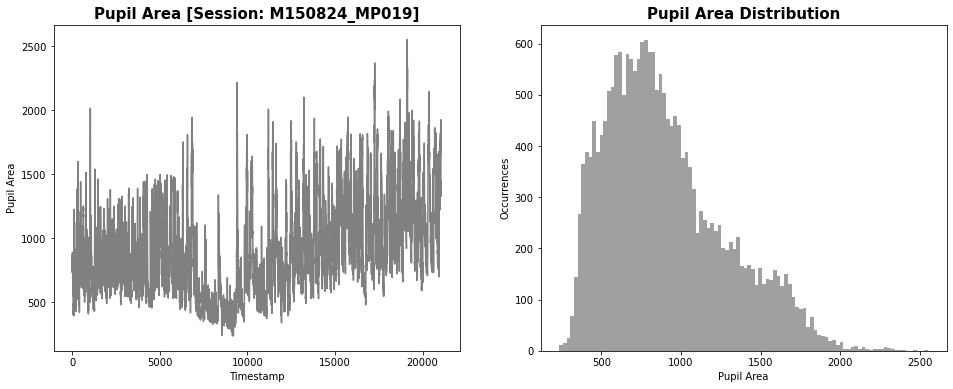

In [6]:
# Pupil Area
spont_dataset0.display_pupil_area()

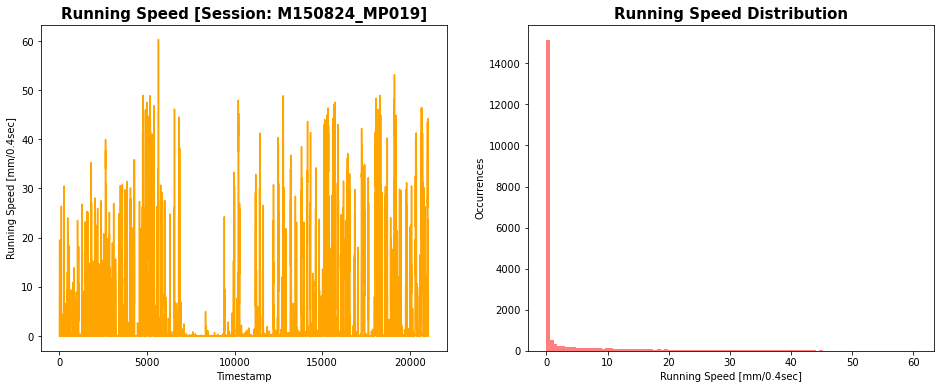

In [7]:
# Running speed time series
spont_dataset0.display_run_speed()

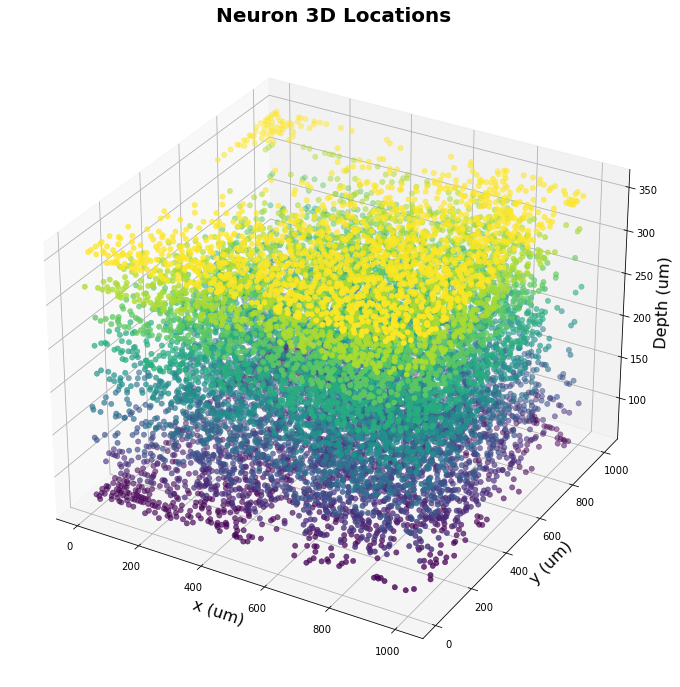

In [8]:
# Neuron locations
plt.figure(figsize=(13, 12))
spont_dataset0.display_neuron_3d(session_name="Spontaneous Session 0")

In [9]:
# Number of neurons per layer
for layer in range(9):
    print("Layer", layer,": ", spont_dataset0.get_layer_fsp(layer).shape)

Layer 0 :  (1131, 21054)
Layer 1 :  (1183, 21054)
Layer 2 :  (1218, 21054)
Layer 3 :  (1321, 21054)
Layer 4 :  (1415, 21054)
Layer 5 :  (1471, 21054)
Layer 6 :  (1418, 21054)
Layer 7 :  (1440, 21054)
Layer 8 :  (1386, 21054)


In [10]:
# spont_dataset0.display_single_neuron_fsp(999)#XM: neuron idx range is 0~11982
# spont_dataset0.display_single_neuron_fsp(64)

# spont_dataset0.display_single_neuron_fsp(1168)

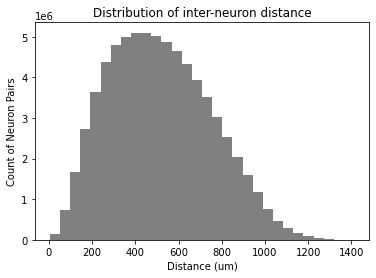

In [11]:
# Inter-neuron Distance Distribution
dist = spont_dataset0.inter_neuron_distance(plot=True)

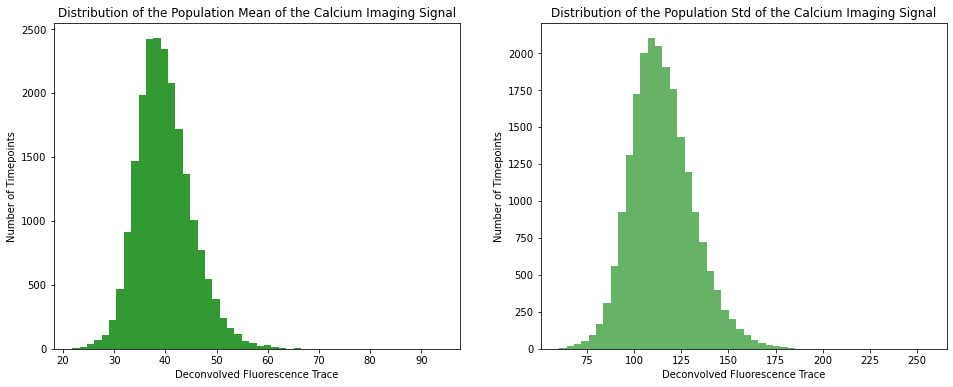

In [12]:
# Display Calcium Trace Mean and Std Distribution
spont_dataset0.display_fsp_distribution_all_time()

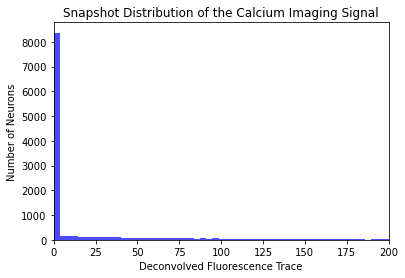

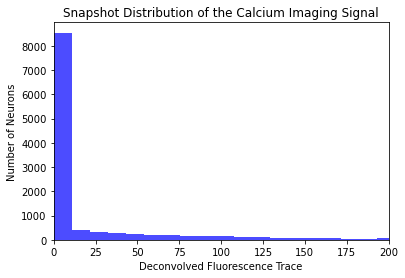

In [13]:
# Display Calcium Trace Distribution at a Specific Instant
spont_dataset0.display_fsp_distribution_instant(timepoint=1000, bins=500)
spont_dataset0.display_fsp_distribution_instant(timepoint=10, bins=150)

# Load all 9 datasets
NOTE: Change the DATA_DIR to your local path of the data directory!
  
While loading the datasets, the loader automatically removes the ill-formatted entries.

In [14]:
# # Input data matrices
# SpontData = dict()

# for SIDX in range(9):
#     # Load Data
#     spont_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], 
#                                     spont_mat[SIDX][glb.REC_DATE][0]])
#     spont_dataset = SpontaneousRecordingData(data_fp=spont_fp)
#     SpontData[SIDX] = spont_dataset
#     print(SIDX, spont_dataset.fsp.shape)
    

## Model Input
<font color=red> Can be modified: </font> For each of the 9 datasets, we randomly select 200 neurons at each depth and take their recorded activity from approximately minute 10 to minute 30. We intentionally omit the first 10 minutes of recording to avoid a burn-in period when the experimented mouse was not well adapted yet to the new environment. 

In [15]:
# Select samples from approximately minute 10 - 30
Start_tp = 1800
End_tp = 5400
Tps = End_tp - Start_tp
Neuron_count =  200
c_percentages = np.arange(0.35, 1, 0.05)

## Use QuicGraphLasso as the Ground Truth

In [16]:
# subset the dataset in all three dimensions
# - select layer 0, 2, 3
# - consider only timestamp from 100 to 1000
# - consider horizontal region of ratio 0.1 - 0.3 w.r.t. the original plane
partial_spont0 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[0,1,2,3,4], start_timepoint=100, end_timepoint=1000, 
                                           x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)


In [17]:
# Substitute with graphical lasso for windows
from sklearn.covariance import graphical_lasso, GraphicalLassoCV
# from inverse_covariance import QuicGraphLasso
from statsmodels.stats.moment_helpers import cov2corr, corr2cov

def get_prec_skggm(spont_data, display=False):
    prec_sample = spont_data.sample_precision_matrix(display=display)

    
#     skggm_model = QuicGraphLasso(
#     lam=0.1,  # Graphical lasso penalty (scalar or matrix)
#     mode='default',               # 'default': single estimate
#     )
#     skggm_model.fit(prec_sample) 
    
    graLas = graphical_lasso(prec_sample, alpha = 0.001)
    

    prec_skggm = graLas[1]
    if display:
        title = "precision matrix"
        plt.title(title, fontsize=16, fontweight="bold")
        plt.imshow(prec_skggm, cmap=plt.cm.get_cmap("RdBu_r"))
        plt.xticks(())
        plt.yticks(())
        
    return cov2corr(prec_skggm)#normalize

array([[ 1.04037705e-03, -2.51032054e-06,  4.29790590e-05, ...,
        -2.73114240e-05,  6.09887507e-06,  4.09227050e-05],
       [-2.51032054e-06,  3.71209776e-03, -1.74432286e-05, ...,
         9.37918519e-06, -3.17917142e-05, -9.47772590e-06],
       [ 4.29790590e-05, -1.74432286e-05,  5.92661707e-04, ...,
        -7.24805824e-07,  2.78806593e-06,  3.72891205e-06],
       ...,
       [-2.73114240e-05,  9.37918519e-06, -7.24805824e-07, ...,
         2.76002749e-04,  4.97965931e-06,  1.64881068e-06],
       [ 6.09887507e-06, -3.17917142e-05,  2.78806593e-06, ...,
         4.97965931e-06,  1.63842886e-04,  1.23377214e-06],
       [ 4.09227050e-05, -9.47772590e-06,  3.72891205e-06, ...,
         1.64881068e-06,  1.23377214e-06,  4.65217525e-04]])

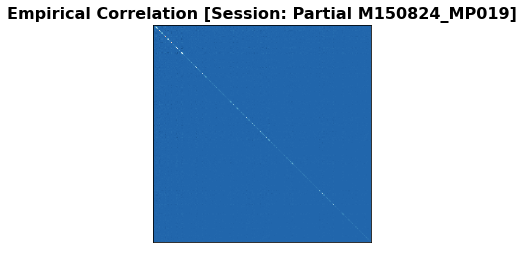

In [18]:
# prec_skggm0 = get_prec_skggm(partial_spont0, display=False)
partial_spont0.sample_precision_matrix(display=display)

In [19]:
partial_spont0.fsp.shape

(253, 900)

In [20]:
graLas_CV = GraphicalLassoCV().fit(X = np.transpose(partial_spont0.fsp))

In [21]:
graLas_CV.alpha_

872.7743985901446

In [22]:
graLas_CV.covariance_

array([[1385.25874652,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  363.7964872 ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 2305.48989181, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 5074.38581755,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        8805.13616649,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 3071.97293147]])

In [23]:
shrinking.checkPD(graLas_CV.covariance_) 

True

In [24]:
cov2corr(graLas_CV.get_precision())

array([[ 1.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  1.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  1., ...,  0.,  0., -0.],
       ...,
       [-0., -0.,  0., ...,  1.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  1., -0.],
       [ 0., -0., -0., ...,  0., -0.,  1.]])

In [25]:
cov2corr(graLas_CV.get_precision()).shape

(253, 253)

In [26]:
np.sum(cov2corr(graLas_CV.get_precision()))

235.80327070001698

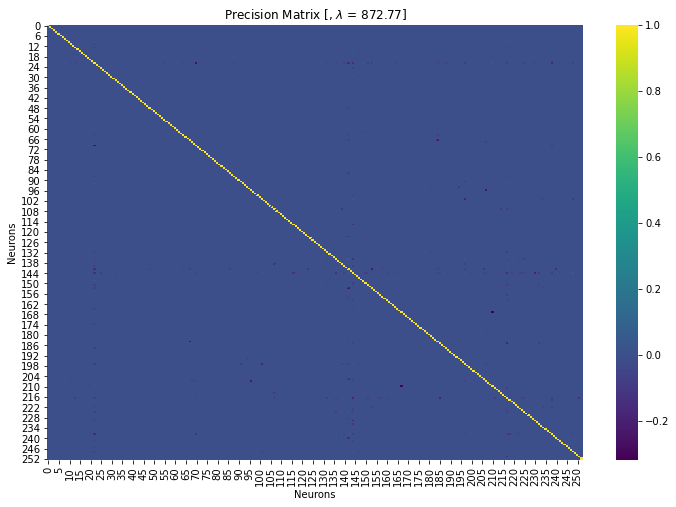

In [27]:
plt.figure(figsize = (12,8))
plot_utils.plot_prec(cov2corr(graLas_CV.get_precision()), alpha = graLas_CV.alpha_)

<Figure size 1080x720 with 0 Axes>

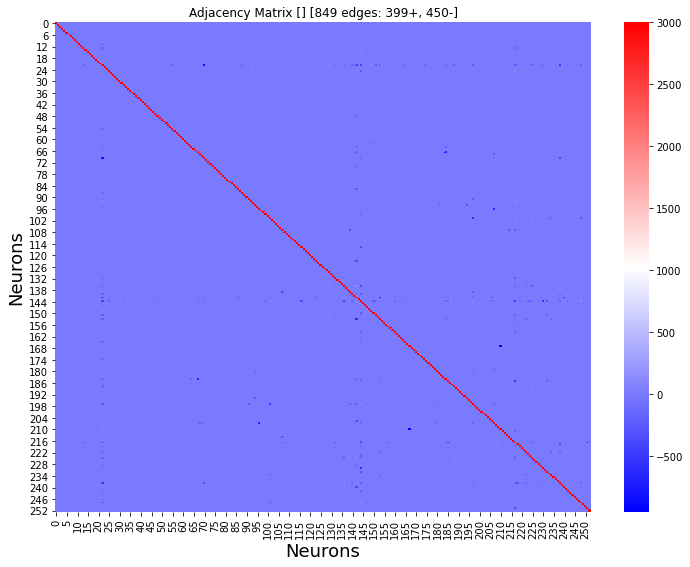

In [28]:
plt.figure(figsize = (15,10))
plot_utils.plot_adj_mat(cov2corr(graLas_CV.get_precision()), include_negs=True)

In [29]:
def prepare_data_prec(spont_data, prec):
    fsp = spont_data.fsp
    # print("fsp has shape (neuron count, timestamp count) = ", fsp.shape)
    X = []
    y = [] 
    for i,f1 in enumerate(fsp):
        for j,f2 in enumerate(fsp):
            X.append(np.concatenate((f1,f2)))
            y.append(prec[i,j])
    X = np.array(X)
    y = np.array(y)
    return X,y

X,y = prepare_data_prec(partial_spont0, cov2corr(graLas_CV.get_precision()))
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

X.shape =  (64009, 1800)
y.shape =  (64009,)


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test0, y_train, y_test0 = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_test, X_validation, y_test, y_validation = train_test_split(X_test0, y_test0, test_size=0.333, random_state=42, shuffle=True)

print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)
print("X_validation.shape = ", X_validation.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)
print("y_validation.shape = ", y_validation.shape)

X_train.shape =  (44806, 1800)
X_test.shape =  (12808, 1800)
X_validation.shape =  (6395, 1800)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)


In [32]:
# from keras.models import Model, Input
# from keras.layers import Dense

# import keras.backend as K

Using TensorFlow backend.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])



model.compile(optimizer='adam',     
              loss= 'mean_squared_error',  
              metrics=['mse'])

model.fit(X_train, y_train, epochs=3, validation_data=(X_validation, y_validation))

In [184]:
print("Evaluation:")
print('test MSE:', model.evaluate(X_test, y_test))

Evaluation:
12808/12808 [==============================] - 1s 41us/sample - loss: 0.0038 - mse: 0.0038
test MSE: [0.003770820763923443, 0.0037708327]


In [31]:
import xgboost as xgb
xg_reg_0 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, max_depth = 3, reg_lambda = 3)

In [32]:
xg_reg_0.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=3, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [33]:
xg_reg_0.predict(X_validation)

array([ 0.0146015 ,  0.00313884,  0.00017384, ...,  0.00775263,
        0.01595017, -0.00824249], dtype=float32)

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xg_reg_0.predict(X_validation), y_validation)

0.003891276800711865

In [35]:
mean_squared_error(xg_reg_0.predict(X_test), y_test)

0.0036270160145982205

## Get features X (fsp pairs) and labels y (precision matrix entries)

In [85]:
prec_0 = get_prec_skggm(partial_spont0, display=False)
print(prec_0)

[[ 1.  0. -0. ...  0. -0. -0.]
 [ 0.  1.  0. ... -0.  0.  0.]
 [-0.  0.  1. ...  0. -0. -0.]
 ...
 [ 0. -0.  0. ...  1. -0. -0.]
 [-0.  0. -0. ... -0.  1. -0.]
 [-0.  0. -0. ... -0. -0.  1.]]


In [86]:
np.all(np.linalg.eigvals(prec_0) > 0)

True

In [87]:
def prepare_data(spont_data):
    prec_skggm = get_prec_skggm(spont_data, display=False)
    fsp = spont_data.fsp
    # print("fsp has shape (neuron count, timestamp count) = ", fsp.shape)
    X = []
    y = [] 
    for i,f1 in enumerate(fsp):
        for j,f2 in enumerate(fsp):
            X.append(np.concatenate((f1,f2)))
            y.append(prec_skggm[i,j])
    X = np.array(X)
    y = np.array(y)
    return X,y

X,y = prepare_data(partial_spont0)
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

X.shape =  (64009, 1800)
y.shape =  (64009,)


In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test0, y_train, y_test0 = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_test, X_validation, y_test, y_validation = train_test_split(X_test0, y_test0, test_size=0.333, random_state=42, shuffle=True)

print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)
print("X_validation.shape = ", X_validation.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)
print("y_validation.shape = ", y_validation.shape)

X_train.shape =  (44806, 1800)
X_test.shape =  (12808, 1800)
X_validation.shape =  (6395, 1800)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)


In [26]:

# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(4, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])



model.compile(optimizer='adam',     
              loss= 'mean_squared_error',  
              metrics=['mse'])

model.fit(X_train, y_train, epochs=3, validation_data=(X_validation, y_validation))


Train on 44806 samples, validate on 6395 samples
Epoch 1/3
44806/44806 [==============================] - 13s 281us/sample - loss: 2.6850 - mse: 2.6851 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/3
44806/44806 [==============================] - 12s 274us/sample - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/3
44806/44806 [==============================] - 11s 243us/sample - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040


In [24]:

print("Evaluation:")
print('test MSE:', model.evaluate(X_test, y_test))


Evaluation:
12808/12808 [==============================] - 2s 133us/sample - loss: 0.0037 - mse: 0.0037
test MSE: [0.003733849862796595, 0.003733839]


In [57]:
# Try kernal regression
from statsmodels.nonparametric.kernel_regression import KernelReg

kr = KernelReg(endog = y_train, exog = X_train, var_type = 'c' * X_train.shape[1])



KeyboardInterrupt: 

### Try to test on unseen neurons

In [51]:
#Test on neurons in layers 5 and 6
partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[5,6], start_timepoint=100, end_timepoint=1000, 
                                           x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)

X1,y1 = prepare_data(partial_spont1)
print("X1.shape = ", X1.shape)
print("y1.shape = ", y1.shape)


print("Evaluation on unseen neurons:")
print('test MSE:', model.evaluate(X1, y1))


X1.shape =  (21316, 1800)
y1.shape =  (21316,)
Evaluation on unseen neurons:
21316/21316 [==============================] - 3s 126us/sample - loss: 0.0068 - mse: 0.0068
test MSE: [0.006811670966908031, 0.006811669]


In [54]:
y1

array([ 1., -0.,  0., ..., -0., -0.,  1.])

In [38]:
#Test on neurons in layers 7 and 8
partial_spont2 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[7,8], start_timepoint=100, end_timepoint=1000, 
                                           x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)

X2,y2 = prepare_data(partial_spont2)
print("X2.shape = ", X2.shape)
print("y2.shape = ", y2.shape)


print("Evaluation on unseen neurons:")
print('test MSE:', model.evaluate(X2, y2))


X2.shape =  (16384, 1800)
y2.shape =  (16384,)
Evaluation on unseen neurons:
512/512 [==============================] - 6s 11ms/step - loss: 0.0085 - mse: 0.0085
test MSE: [0.008545414544641972, 0.008545414544641972]


In [90]:
sampler = MissingTraceSampler()

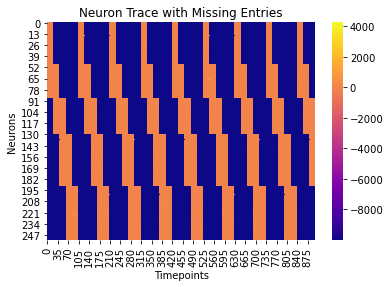

In [91]:
missing_fsp_cont = sampler.missing_fsp_consecutive_layers(dataset=partial_spont0, sim_timestamps=21, sim_layer_size=2, 
                                                          layer_stride=1, display=True)

In [92]:
missing_fsp_cont.shape

(253, 900)

In [93]:
import pandas as pd
missing_fsp_cov = pd.DataFrame(missing_fsp_cont).transpose().cov()
missing_fsp_cov

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,1141.680499,59.703350,-99.432379,-51.838340,-6.763675,14.874275,-17.992324,11.639011,37.631308,-59.305303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59.703350,483.784607,-52.164181,10.135294,-7.830798,28.766468,-97.800690,4.965160,63.472538,-18.414666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-99.432379,-52.164181,2185.686660,25.359965,-11.517098,-64.229182,331.623211,-1.435070,96.070567,-143.136191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-51.838340,10.135294,25.359965,152.161635,3.963536,-18.937105,47.895902,-0.053688,20.539825,9.273365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-6.763675,-7.830798,-11.517098,3.963536,119.404143,-18.249846,2.251124,28.690229,-2.183667,23.342661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-501.106559,-773.005252,404.386468,775.881332,166.304264,28217.891577,109.640636,495.473776,573.426878,-494.645074
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-140.319882,57.078073,2.884051,184.905405,79.654065,109.640636,1252.869533,98.492882,176.841631,-116.258431
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97.308047,-45.599330,167.674685,227.173644,141.134692,495.473776,98.492882,5686.369788,30.213647,-219.806183
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-49.769803,165.404031,108.158074,55.361471,218.446298,573.426878,176.841631,30.213647,4569.461820,209.992136


In [97]:
missing_fsp_corr = cov2corr(missing_fsp_cov.fillna(0))
missing_fsp_corr

array([[ 1.        ,  0.08033418, -0.06294505, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08033418,  1.        , -0.05072855, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06294505, -0.05072855,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.00592725, -0.05214992],
       [ 0.        ,  0.        ,  0.        , ...,  0.00592725,
         1.        ,  0.05557786],
       [ 0.        ,  0.        ,  0.        , ..., -0.05214992,
         0.05557786,  1.        ]])

In [104]:
shrinking.checkPD(missing_fsp_corr)

ValueError: The matrix is not positive definite

In [100]:
missing_fsp_corr_near = nearest_correlation.nearcorr(missing_fsp_corr)
missing_fsp_corr_near

array([[ 1.00000000e+00,  8.02011291e-02, -6.25397338e-02, ...,
         1.44065275e-03, -1.37335700e-03,  4.98537622e-04],
       [ 8.02011291e-02,  1.00000000e+00, -5.13505073e-02, ...,
        -6.96882825e-04,  2.39430430e-04,  7.47865324e-04],
       [-6.25397338e-02, -5.13505073e-02,  1.00000000e+00, ...,
         4.28414925e-04, -1.38083068e-05, -1.16157160e-04],
       ...,
       [ 1.44065275e-03, -6.96882825e-04,  4.28414925e-04, ...,
         1.00000000e+00,  1.14198071e-02, -5.24587601e-02],
       [-1.37335700e-03,  2.39430430e-04, -1.38083068e-05, ...,
         1.14198071e-02,  1.00000000e+00,  5.87044238e-02],
       [ 4.98537622e-04,  7.47865324e-04, -1.16157160e-04, ...,
        -5.24587601e-02,  5.87044238e-02,  1.00000000e+00]])

In [107]:
np.all(np.linalg.eigvals(missing_fsp_corr_near) >= 0) 

False

In [109]:
np.sum(np.isnan(missing_fsp_corr_near))

0

In [64]:
prec_mat_0 = cov2corr(np.linalg.inv(cov2corr(missing_fsp_cov.fillna(0))))
prec_mat_0

array([[ 1.        , -0.25507986,  0.3454544 , ...,  0.74049669,
         0.12896566,  0.56256799],
       [-0.25507986,  1.        , -0.15789612, ...,  0.00861247,
         0.23484858,  0.04414549],
       [ 0.3454544 , -0.15789612,  1.        , ...,  0.0963529 ,
         0.09127801,  0.3211043 ],
       ...,
       [ 0.74049669,  0.00861247,  0.0963529 , ...,  1.        ,
         0.36129171,  0.22535106],
       [ 0.12896566,  0.23484858,  0.09127801, ...,  0.36129171,
         1.        ,  0.49630677],
       [ 0.56256799,  0.04414549,  0.3211043 , ...,  0.22535106,
         0.49630677,  1.        ]])